In [6]:
# Setup for Clipper R kernel

# Make sure both your personal lib and the system libs are visible
.libPaths(c(
  "/mnt/home/bisholea/Rlibs",
  "/opt/gvsu/clipper/2025.05/R/4.4.3/library",
  "/opt/gvsu/clipper/2025.05/spack/apps/linux-rhel9-cascadelake/gcc-13.3.1/r-4.4.3-gz7onk2vbizgd2zxqa6ij47gygl6dsd4/rlib/R/library"
))

# Quick sanity check (optional, just to see)
.libPaths()
"ggplot2" %in% rownames(installed.packages())

# Load the packages you already have
library(readr)
library(dplyr)
library(tidyr)
library(ggplot2)
library(fgsea)
library(cowplot)

[1] "/mnt/home/bisholea/Rlibs"                                                                                                       
[2] "/opt/gvsu/clipper/2025.05/R/4.4.3/library"                                                                                      
[3] "/opt/gvsu/clipper/2025.05/spack/apps/linux-rhel9-cascadelake/gcc-13.3.1/r-4.4.3-gz7onk2vbizgd2zxqa6ij47gygl6dsd4/rlib/R/library"

[1] TRUE

In [7]:
#!/usr/bin/env Rscript
suppressPackageStartupMessages({
  library(readr); library(dplyr); library(tidyr); library(tibble)
  library(purrr); library(ggplot2)
})

set.seed(1)

# ---------------- paths ----------------
capstone_dir <- "/mnt/projects/debruinz_project/bisholea/capstone"
gsea_dir     <- file.path(capstone_dir, "gsea")
fig_dir      <- file.path(capstone_dir, "figures")
dir.create(fig_dir, showWarnings = FALSE, recursive = TRUE)

# ---------------- load centralized data/style ----------------
fd <- readRDS(file.path(gsea_dir, "figdata.rds"))

# override theme locally for this script
fd$style$theme <- function() {
  ggplot2::theme_classic(base_size = 12, base_family = "serif") +
    ggplot2::theme(
      panel.grid          = ggplot2::element_blank(),
      plot.title.position = "plot",
      legend.title        = ggplot2::element_blank(),
      plot.margin         = ggplot2::margin(t = 3, r = 3, b = 3, l = 3),
      axis.title.x        = ggplot2::element_text(margin = ggplot2::margin(t = 4)),
      axis.title.y        = ggplot2::element_text(margin = ggplot2::margin(r = 4)),
      axis.ticks.length   = grid::unit(2, "pt")
    )
}

# palette + theme from figdata
pal_model <- if (!is.null(fd$palettes$model)) {
  fd$palettes$model
} else {
  c(AE = viridisLite::viridis(7)[4], NMF = "grey75")
}

plt_theme <- fd$style$theme()


save_pdf <- function(path, plot, w=7, h=5) {
  if (isTRUE(capabilities("cairo"))) {
    ggsave(path, plot, width=w, height=h, units="in", device=cairo_pdf, bg="white")
  } else {
    ggsave(path, plot, width=w, height=h, units="in", device="pdf", bg="white", useDingbats=FALSE)
  }
}

read_wide_matrix <- function(path, pathway_col = "pathway") {
  header <- readr::read_lines(path, n_max = 1)
  cols   <- strsplit(header, ",", fixed = TRUE)[[1]]
  pw_col <- if (pathway_col %in% cols) pathway_col else cols[1]
  other  <- setdiff(cols, pw_col)
  ct <- do.call(readr::cols, c(
    setNames(list(readr::col_character()), pw_col),
    setNames(rep(list(readr::col_double()), length(other)), other)
  ))
  df <- readr::read_csv(path, col_types = ct, show_col_types = FALSE)
  rn <- df[[pw_col]]; df[[pw_col]] <- NULL
  m <- as.matrix(df); rownames(m) <- rn; m
}

Warning message:
“No shared levels found between `names(values)` of the manual scale and the
data's colour values.”
Warning message:
“Removed 105 rows containing missing values or values outside the scale range
(`geom_violin()`).”
Warning message:
“No shared levels found between `names(values)` of the manual scale and the
data's colour values.”
Warning message:
“Removed 105 rows containing missing values or values outside the scale range
(`geom_violin()`).”
Warning message:
“Removed 8 rows containing non-finite outside the scale range (`stat_bin()`).”
Warning message:
“Removed 8 rows containing non-finite outside the scale range (`stat_bin()`).”


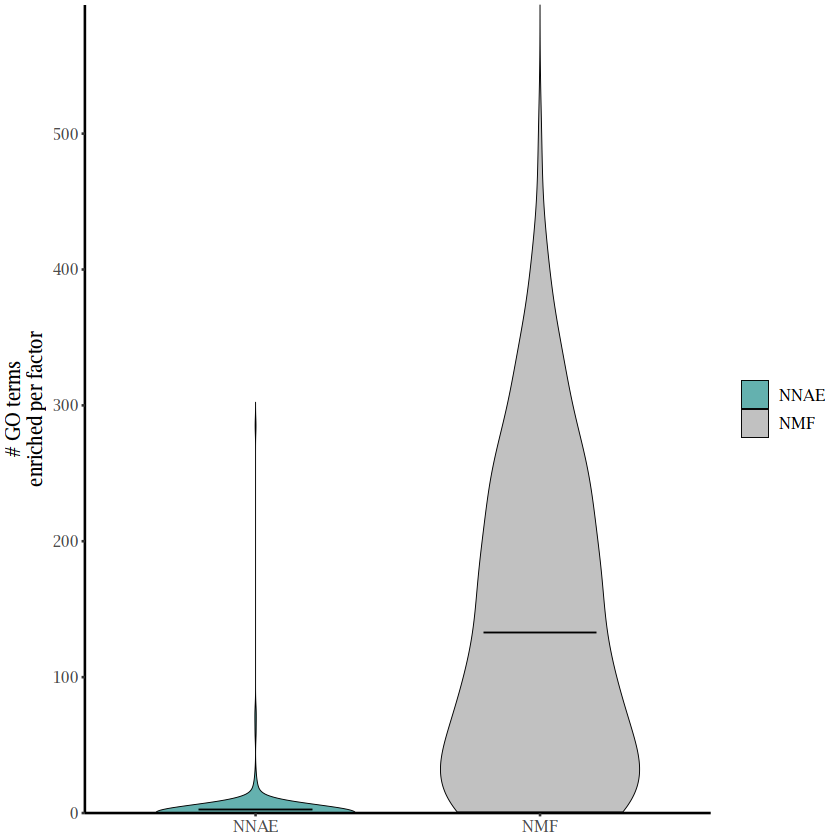

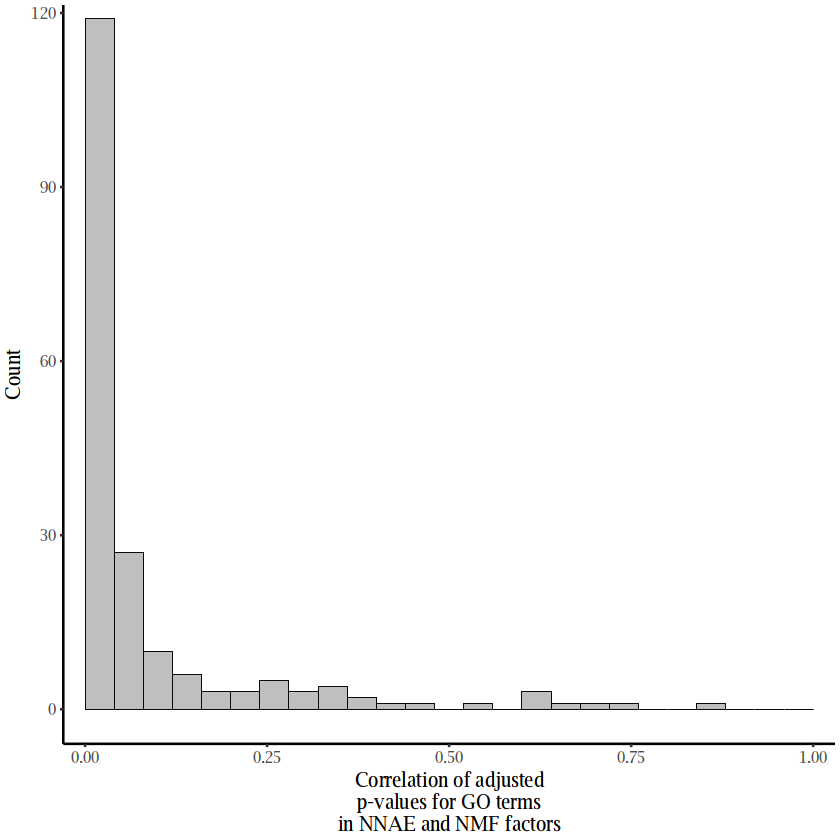

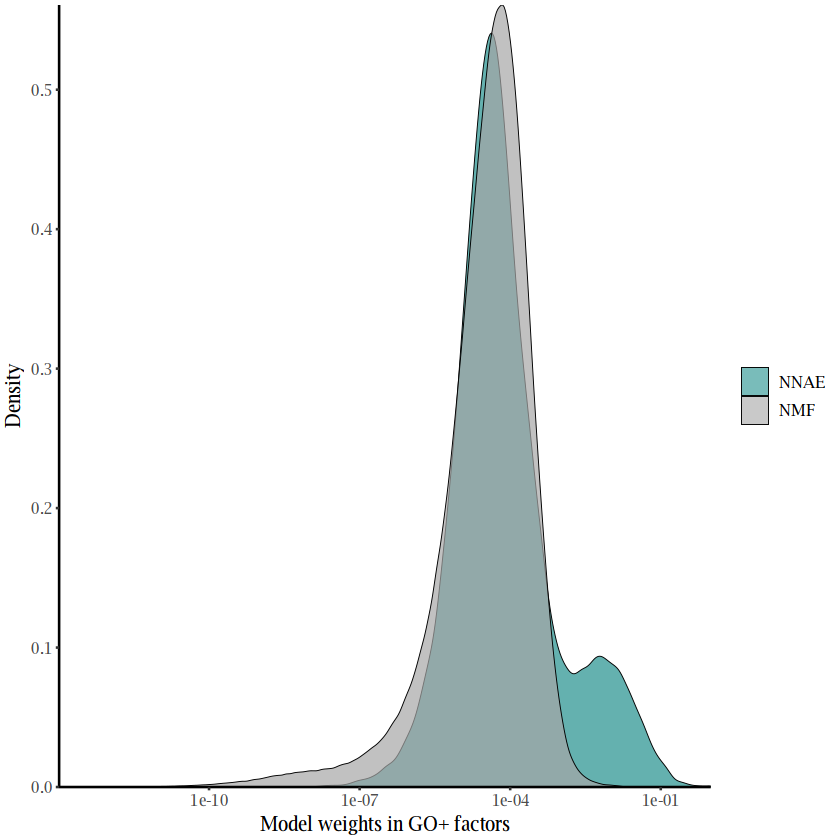

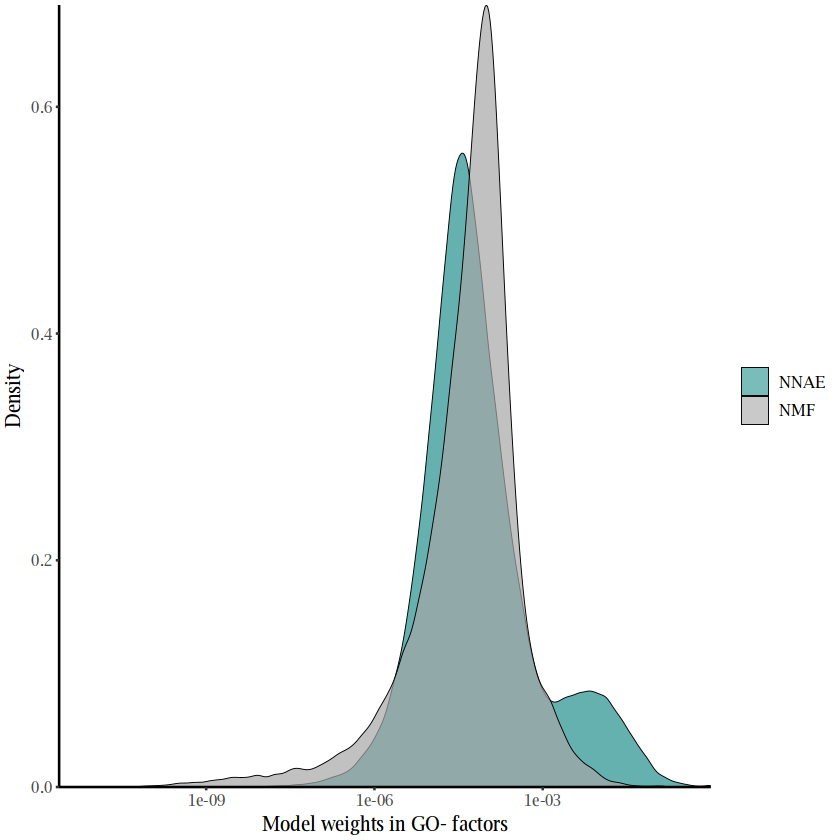

In [3]:
# ==========================================================
# A) Enriched GO terms per factor (AE vs NMF)
# ==========================================================
if (!is.null(fd$counts$ae) && !is.null(fd$counts$nmf)) {
  df_counts <- bind_rows(
    fd$counts$ae  %>% mutate(model = "AE")  %>% select(model, n_sig),
    fd$counts$nmf %>% mutate(model = "NMF") %>% select(model, n_sig)
  ) %>%
    mutate(model = factor(model, levels = c("AE","NMF"))) %>%
    dplyr::filter(is.finite(n_sig), n_sig >= 0)


p_gsea_counts <- ggplot(df_counts, aes(x = model, y = n_sig, fill = model)) +
  # 1) Jitter behind violin
  # geom_jitter(
  #   aes(color = model),
  #   width  = 0.12,
  #   height = 0,
  #   size   = 1.0,
  #   alpha  = 0.25,
  #   show.legend = FALSE
  # ) +
  # 2) Violin on top
  geom_violin(
    width     = 0.7,
    alpha     = 0.7,
    color     = "black",
    linewidth = 0.2,
    trim      = FALSE,
    scale     = "width"
  ) +
  # 3) Mean line per group
  stat_summary(
    fun        = mean,
    geom       = "crossbar",
    width      = 0.4,
    color      = "black",
    linewidth  = 0.3,
    fatten     = 1.3,
    show.legend = FALSE
  ) +
  # 4) Colors + labels
  scale_fill_manual(
    values = pal_model,
    labels = c(AE = "NNAE", NMF = "NMF")
  ) +
  scale_color_manual(
    values = pal_model,
    labels = c(AE = "NNAE", NMF = "NMF")
  ) +
  scale_x_discrete(
    labels = c(AE = "NNAE", NMF = "NMF")
  ) +
  scale_y_continuous(
    limits = c(0, NA),
    expand = c(0, 0.02)
  ) +
  labs(
    x = NULL,
    y = "# GO terms\nenriched per factor"
  ) +
  plt_theme

  # smaller physical size, same font
  save_pdf(file.path(fig_dir, "gsea_counts.pdf"), p_gsea_counts,
           w = 4.5, h = 3.5)
  print(p_gsea_counts)
} else {
  message("[Note] fd$counts$ae or fd$counts$nmf missing — skipping GO-term counts figure.")
}

# ==========================================================
# B) R^2 Padj distribution
# ==========================================================

# R2 of -log10(padj)
r2_pairs <- fd$gsea$r2_pairs

p_r2_logp <- ggplot(r2_pairs, aes(x = R2_mlog10_all)) +
  geom_histogram(
    breaks   = seq(0, 1, length.out = 25 + 1),
    color    = "black",    # black outline around bars
    linewidth = 0.2,
    fill     = "grey75"
  ) +
  scale_x_continuous(
    limits = c(0, 1),
    expand = c(0, 0.03)
  ) +
  scale_y_continuous(
    limits = c(0, NA),
    # add some space between the x-axis and the first bar
    expand = expansion(mult = c(0.05, 0.02))
  ) +
  labs(
    x = "Correlation of adjusted\np-values for GO terms\nin NNAE and NMF factors",
    y = "Count"
  ) +
  plt_theme 
  
save_pdf(file.path(fig_dir, "r2_logpadj_distribution.pdf"), p_r2_logp,
         w = 4.5, h = 3.5)
print(p_r2_logp)


# ==========================================================
# C-D) Pooled density of non-zero weights: GO+ and GO−
#     (uses fd$meta$preproc_rds and fd$counts to define GO+/GO−)
# ==========================================================
stopifnot(!is.null(fd$meta$preproc_rds), file.exists(fd$meta$preproc_rds))
stopifnot(!is.null(fd$counts$ae), !is.null(fd$counts$nmf))

pp <- readRDS(fd$meta$preproc_rds)
ae_W_common  <- as.data.frame(pp$ae_W_common)
nmf_W_common <- as.data.frame(pp$nmf_W_common)

make_factor_meta <- function(counts_df) {
  counts_df %>% transmute(factor, n_sig, GO_group = if_else(n_sig > 0, "GO+", "GO-"))
}
ae_meta  <- make_factor_meta(fd$counts$ae)
nmf_meta <- make_factor_meta(fd$counts$nmf)

build_density_df <- function(W_common, factor_meta, model,
                             go_group = c("GO+","GO-"), max_rows = 1e6) {
  go_group <- match.arg(go_group)
  factors_to_plot <- factor_meta %>%
    filter(GO_group == go_group) %>%
    pull(factor) %>%
    intersect(colnames(W_common))
  if (length(factors_to_plot) == 0L) {
    warning(sprintf("[%s %s] No matching factors found.", model, go_group))
    return(tibble())
  }
  rows_idx <- if (nrow(W_common) > max_rows) sample.int(nrow(W_common), max_rows) else seq_len(nrow(W_common))
  as.data.frame(W_common[rows_idx, factors_to_plot, drop = FALSE]) %>%
    pivot_longer(everything(), names_to = "factor", values_to = "weight") %>%
    mutate(Model = model, GO_group = go_group) %>%
    filter(is.finite(weight), weight > 0)
}

# palette in AE/NMF name order to match Model factor below
pal_fill <- c(AE = unname(pal_model["AE"]), NMF = unname(pal_model["NMF"]))

# ---------- GO+ ----------
df_pos <- bind_rows(
  build_density_df(ae_W_common,  ae_meta,  "AE",  "GO+"),
  build_density_df(nmf_W_common, nmf_meta, "NMF", "GO+")
) %>% mutate(Model = factor(Model, levels = c("AE","NMF")))

p_go_pos <- ggplot(df_pos, aes(x = weight, fill = Model)) +
  geom_density(alpha = 0.7, adjust = 1.2, linewidth = 0.2, color = "black") +
  scale_fill_manual(
    values = pal_fill,
    labels = c(AE = "NNAE", NMF = "NMF")
  ) +
  scale_x_log10(
    expand = c(0, 0)     # <- no horizontal padding
  ) +
  scale_y_continuous(
    limits = c(0, NA),   # <- baseline at 0
    expand = c(0, 0)     # <- no vertical padding
  ) +
  labs(
    x = "Model weights in GO+ factors", y = "Density"
  ) +
  plt_theme +
  guides(fill = guide_legend(override.aes = list(alpha = 0.6)))

save_pdf(file.path(fig_dir, "density_GOpos_AE_vs_NMF.pdf"), p_go_pos,
         w = 4.5, h = 3.5)
print(p_go_pos)

# ---------- GO− ----------
df_neg <- bind_rows(
  build_density_df(ae_W_common,  ae_meta,  "AE",  "GO-"),
  build_density_df(nmf_W_common, nmf_meta, "NMF", "GO-")
) %>% mutate(Model = factor(Model, levels = c("AE","NMF")))

p_go_neg <- ggplot(df_neg, aes(x = weight, fill = Model)) +
  geom_density(alpha = 0.7, adjust = 1.2, linewidth = 0.2, color = "black") +
  scale_fill_manual(
    values = pal_fill,
    labels = c(AE = "NNAE", NMF = "NMF")
  ) +
  scale_x_log10(
    expand = c(0, 0)
  ) +
  scale_y_continuous(
    limits = c(0, NA),
    expand = c(0, 0)
  ) +
  labs(
    x = "Model weights in GO- factors", y = "Density"
  ) +
  plt_theme +
  guides(fill = guide_legend(override.aes = list(alpha = 0.6)))

save_pdf(file.path(fig_dir, "density_GOneg_AE_vs_NMF.pdf"), p_go_neg,
         w = 4.5, h = 3.5)
print(p_go_neg)

# ==========================================================
# E-F) faceted bubble plotting (NMF / AE / Both)
# ==========================================================

# ---- load GSEA matrices and align pathway universe ----
ae_nes   <- read_wide_matrix(fd$gsea$paths$ae_nes_csv)
nmf_nes  <- read_wide_matrix(fd$gsea$paths$nmf_nes_csv)
ae_padj  <- read_wide_matrix(fd$gsea$paths$ae_padj_csv)
nmf_padj <- read_wide_matrix(fd$gsea$paths$nmf_padj_csv)

pw_common <- Reduce(
  intersect,
  list(
    rownames(ae_nes),
    rownames(nmf_nes),
    rownames(ae_padj),
    rownames(nmf_padj)
  )
)

ae_nes   <- ae_nes [pw_common, , drop = FALSE]
nmf_nes  <- nmf_nes[pw_common, , drop = FALSE]
ae_padj  <- ae_padj[pw_common, , drop = FALSE]
nmf_padj <- nmf_padj[pw_common, , drop = FALSE]

bp    <- fd$matching$best_pairs  # ae_index, nmf_index, cosine
alpha <- if (!is.null(fd$alpha)) fd$alpha else 0.01  # (not used below; can remove)

.safe_log10p <- function(p, floor = 1e-300) {
  ifelse(is.finite(p), -log10(pmax(p, floor)), 0)
}

collapse_rds      <- file.path(gsea_dir, "collapsed_panels_allPairs_alpha0.1.rds")
collapsed_panels  <- readRDS(collapse_rds)

TOP_K_PER_PANEL <- 5   # you asked for 5 per panel
SIZE_MAX        <- 12

# ----------------------------------------------------------
# Long-format bubble data for one pair, no collapse filter yet
# ----------------------------------------------------------
make_bubble_df <- function(ai, ni) {
  stopifnot(ai %in% seq_len(ncol(ae_nes)), ni %in% seq_len(ncol(nmf_nes)))

  base <- tibble::tibble(
    pathway = rownames(ae_nes),
    AE_NES  = ae_nes[,  ai, drop = TRUE],
    NMF_NES = nmf_nes[, ni, drop = TRUE],
    AE_p    = ae_padj[,  ai, drop = TRUE],
    NMF_p   = nmf_padj[, ni, drop = TRUE]
  ) |>
    dplyr::filter(is.finite(AE_NES) & is.finite(NMF_NES)) |>
    dplyr::mutate(
      AE_logP  = .safe_log10p(AE_p),
      NMF_logP = .safe_log10p(NMF_p)
    )

  df <- dplyr::bind_rows(
    dplyr::transmute(base, pathway, model = "AE",  NES = AE_NES,  logP = AE_logP),
    dplyr::transmute(base, pathway, model = "NMF", NES = NMF_NES, logP = NMF_logP)
  )

  y_order <- df |>
    dplyr::group_by(pathway) |>
    dplyr::summarise(order_key = max(abs(NES), na.rm = TRUE), .groups = "drop") |>
    dplyr::arrange(order_key) |>
    dplyr::pull(pathway)

  df |>
    dplyr::mutate(
      pathway_full  = pathway,
      pathway_short = ifelse(
        nchar(pathway) > 55,
        paste0(substr(pathway, 1, 52), "..."),
        pathway
      ),
      pathway     = factor(pathway, levels = y_order),
      pathway_chr = as.character(pathway)
    )
}

# ----------------------------------------------------------
# Build facet df for ONE pair from precomputed collapsed_panels
# ----------------------------------------------------------
make_facet_df_for_pair <- function(pair_rank,
                                   top_k_per_panel = TOP_K_PER_PANEL,
                                   sig_alpha = 0.1) {

  pair_rows <- collapsed_panels %>%
    dplyr::filter(pair_rank == !!pair_rank)

  if (!nrow(pair_rows)) {
    message(
      sprintf(
        "Pair %d has no collapsed pathways; facet plot will be empty.",
        pair_rank
      )
    )
    return(tibble::tibble())
  }

  ai <- pair_rows$ae_index[[1]]
  ni <- pair_rows$nmf_index[[1]]

  # all pathways (finite NES) for this pair
  df_all <- make_bubble_df(ai, ni)

  # restrict to non-redundant pathways from collapsePathways
  keep_paths <- unique(pair_rows$pathway)

  df_fac <- df_all %>%
    dplyr::filter(pathway_chr %in% keep_paths) %>%
    # attach padj for both models
    dplyr::mutate(
      AE_p    = ae_padj[pathway_chr, ai],
      NMF_p   = nmf_padj[pathway_chr, ni],
      AE_sig  = is.finite(AE_p)  & AE_p  <= sig_alpha,
      NMF_sig = is.finite(NMF_p) & NMF_p <= sig_alpha
    ) %>%
    # define panels by significance pattern
    dplyr::mutate(
      panel = dplyr::case_when(
        AE_sig  & !NMF_sig ~ "AE",
        NMF_sig & !AE_sig  ~ "NMF",
        AE_sig  &  NMF_sig ~ "Both",
        TRUE               ~ NA_character_
      )
    ) %>%
    dplyr::filter(!is.na(panel))

  if (!nrow(df_fac)) {
    message(
      sprintf(
        "Pair %d: no pathways passing significance pattern; facet plot will be empty.",
        pair_rank
      )
    )
    return(tibble::tibble())
  }

  # -------- NES-based scoring per (panel, pathway) --------
  scores <- df_fac %>%
    dplyr::group_by(panel, pathway_chr) %>%
    dplyr::summarise(
      AE_NES  = max(NES[model == "AE"],  na.rm = TRUE),
      NMF_NES = max(NES[model == "NMF"], na.rm = TRUE),
      .groups = "drop"
    ) %>%
    dplyr::mutate(
      score = dplyr::case_when(
        panel == "AE"   ~ AE_NES,
        panel == "NMF"  ~ NMF_NES,
        panel == "Both" ~ pmin(AE_NES, NMF_NES),
        TRUE            ~ NA_real_
      )
    )

  # -------- pick top K pathways per panel (by NES-based score) --------
  if (!is.null(top_k_per_panel)) {
    top_paths <- scores %>%
      dplyr::group_by(panel) %>%
      dplyr::slice_max(
        order_by  = score,
        n         = top_k_per_panel,
        with_ties = FALSE
      ) %>%
      dplyr::ungroup() %>%
      dplyr::select(panel, pathway_chr)

    df_fac <- df_fac %>%
      dplyr::inner_join(top_paths, by = c("panel", "pathway_chr"))
  }

  # add short label
  df_fac <- df_fac %>%
    dplyr::mutate(
      pathway_short = ifelse(
        nchar(pathway_chr) > 55,
        paste0(substr(pathway_chr, 1, 52), "..."),
        pathway_chr
      )
    )

  # -------- order within each panel by NES-based score --------
  df_fac <- df_fac %>%
    # attach scores
    dplyr::left_join(
      scores %>% dplyr::select(panel, pathway_chr, score),
      by = c("panel", "pathway_chr")
    ) %>%
    # for each panel, sort by descending score
    dplyr::group_by(panel) %>%
    dplyr::arrange(dplyr::desc(score), .by_group = TRUE) %>%
    dplyr::mutate(
      # panel-specific y id based on full pathway id (no truncation collision)
      y_id = paste(panel, pathway_chr, sep = "::")
    ) %>%
    dplyr::ungroup() %>%
    dplyr::mutate(
      # global factor levels: first in each panel (highest NES) should appear at top
      y_id = factor(y_id, levels = rev(unique(y_id)))
    ) %>%
    dplyr::select(-score)

  # fix panel facet order LAST so joins don't mess it up
  df_fac <- df_fac %>%
    dplyr::mutate(
      panel = factor(panel, levels = c("NMF", "AE", "Both"))
    )

  df_fac
}


plot_facet_bubble_for_pair <- function(pair_rank,
                                       top_k_per_panel = TOP_K_PER_PANEL,
                                       size_limits,
                                       size_breaks,
                                       xlim_fixed = NULL) {
  df <- make_facet_df_for_pair(pair_rank, top_k_per_panel = top_k_per_panel)

  if (!nrow(df)) {
    pair_rows <- collapsed_panels %>% dplyr::filter(pair_rank == !!pair_rank)
    title_txt <- if (nrow(pair_rows)) {
      sprintf(
        "No collapsed pathways for pair %d (AE F%d vs NMF F%d)",
        pair_rank,
        pair_rows$ae_index[[1]], pair_rows$nmf_index[[1]]
      )
    } else {
      sprintf("No collapsed pathways for pair %d", pair_rank)
    }
    return(
      ggplot2::ggplot() +
        ggplot2::theme_void() +
        ggplot2::labs(title = title_txt)
    )
  }

  # --- rename panels for strips: AE → NNAE, Both → Shared ---
  df <- df %>%
    dplyr::mutate(
      panel = factor(
        dplyr::recode(as.character(panel),
                      "NMF"  = "NMF",
                      "AE"   = "NNAE",
                      "Both" = "Shared"),
        levels = c("NMF", "NNAE", "Shared")
      )
    )

  # x-scale per pair (only if xlim_fixed not supplied)
  if (is.null(xlim_fixed)) {
    xr <- range(df$NES, na.rm = TRUE)
    xd <- diff(xr); if (!is.finite(xd) || xd <= 0) xd <- 2.5
    pad <- 0.3
    xlim_fixed <- c(min(xr[1] - pad, 0), max(xr[2] + pad, 0))
  }

  ggplot2::ggplot(df, ggplot2::aes(x = NES, y = y_id)) +
    ggplot2::geom_vline(xintercept = 0, color = "grey88") +
    ggplot2::geom_point(
      ggplot2::aes(size = logP, fill = model),
      shape  = 21,
      color  = "black",
      alpha  = 0.7,
      stroke = 0.25
    ) +
    ggplot2::scale_fill_manual(
      values = pal_model,
      labels = c(AE = "NNAE", NMF = "NMF"),
      name   = "Model"
    ) +
    ggplot2::scale_size_continuous(
      limits = size_limits,
      breaks = size_breaks,
      range  = c(2, SIZE_MAX),
      name   = expression(-log[10](padj)),
      labels = as.character
    ) +
    ggplot2::scale_y_discrete(
      labels = function(vals) {
        lab_map <- setNames(as.character(df$pathway_short), df$y_id)
        lab_map[vals]
      }
    ) +
    ggplot2::guides(
      fill = ggplot2::guide_legend(override.aes = list(size = 4))
    ) +
    ggplot2::coord_cartesian(xlim = xlim_fixed, expand = TRUE, clip = "on") +
    ggplot2::facet_grid(panel ~ ., scales = "free_y", space = "free_y") +
    ggplot2::labs(
      title = sprintf("NNAE/NMF Factor Pair %d", pair_rank),
      x     = "NES",
      y     = "Differentially enriched\nGO terms between models"
    ) +
    plt_theme +
    ggplot2::theme(
      # vertical gridlines back on (light gray), no horizontal grid
      panel.grid.major.x = ggplot2::element_line(colour = "grey90", linewidth = 0.3),
      panel.grid.minor.x = ggplot2::element_blank(),
      panel.grid.major.y = ggplot2::element_blank(),
      panel.grid.minor.y = ggplot2::element_blank(),

      axis.line          = ggplot2::element_blank(),
      axis.ticks.y       = ggplot2::element_blank(),

      axis.text.y        = ggplot2::element_text(size = 9, margin = margin(r = 6)),
      legend.position    = "right",
      legend.box         = "vertical",
      strip.text.y       = ggplot2::element_text(face = "bold"),
      strip.background   = ggplot2::element_rect(fill = "grey92", colour = NA),
      panel.spacing      = grid::unit(0.8, "lines"),
      plot.title         = ggplot2::element_text(hjust = 0.5)
    )
}


# ----------------------------------------------------------
# Global size scale for dots
# ----------------------------------------------------------
pair_ranks <- sort(unique(collapsed_panels$pair_rank))

compute_global_size_limits <- function(sel_ranks,
                                       want_breaks = c(1, 2, 3, 4)) {
  all_logP <- numeric(0)

  for (pr in sel_ranks) {
    row1 <- collapsed_panels %>%
      dplyr::filter(pair_rank == !!pr) %>%
      dplyr::slice(1)

    if (!nrow(row1)) next

    ai <- row1$ae_index[[1]]
    ni <- row1$nmf_index[[1]]

    keep <- is.finite(ae_padj[, ai]) & is.finite(nmf_padj[, ni])
    if (!any(keep)) next

    v <- c(
      -log10(pmax(ae_padj[keep, ai], 1e-300)),
      -log10(pmax(nmf_padj[keep, ni], 1e-300))
    )
    all_logP <- c(all_logP, v[is.finite(v)])
  }

  max_logP <- if (length(all_logP)) max(all_logP) else 4
  lims     <- c(0, max(2, max_logP))
  brks     <- want_breaks[want_breaks <= lims[2]]

  list(limits = lims, breaks = brks)
}

sz <- compute_global_size_limits(
  pair_ranks,
  want_breaks = c(1, 2, 3, 4)
)

# ----------------------------------------------------------
# Driver: ONLY faceted plots
# ----------------------------------------------------------
for (j in pair_ranks) {
  p <- plot_facet_bubble_for_pair(
    pair_rank       = j,
    top_k_per_panel = TOP_K_PER_PANEL,
    size_limits     = sz$limits,
    size_breaks     = sz$breaks
  )

  save_pdf(
    file.path(fig_dir, sprintf("gsea_facet_pair2_%02d.pdf", j)),
    p, w = 8, h = 8
  )

  ggsave(
    file.path(fig_dir, sprintf("gsea_facet_pair2_%02d.png", j)),
    p,
    width  = 8,
    height = 8,
    units  = "in",
    dpi    = 300,
    bg     = "white"
  )
}

Warning message:
“No shared levels found between `names(values)` of the manual scale and the
data's colour values.”
Warning message:
“Removed 105 rows containing missing values or values outside the scale range
(`geom_violin()`).”
Warning message in get_plot_component(plot, "guide-box"):
“Multiple components found; returning the first one. To return all, use `return_all = TRUE`.”
Warning message:
“No shared levels found between `names(values)` of the manual scale and the
data's colour values.”
Warning message:
“Removed 105 rows containing missing values or values outside the scale range
(`geom_violin()`).”
Warning message:
“Removed 8 rows containing non-finite outside the scale range (`stat_bin()`).”
Warning message in get_plot_component(plot, "guide-box"):
“Multiple components found; returning the first one. To return all, use `return_all = TRUE`.”


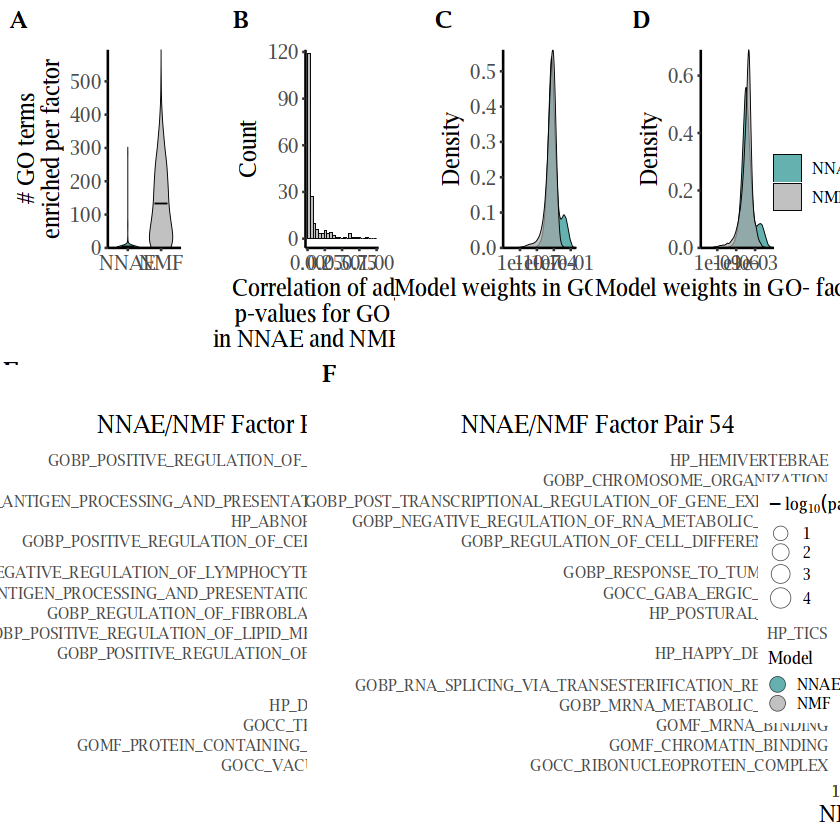

In [ ]:
library(cowplot)
library(ggplot2)

## 0) Extract a shared model legend (for A, C, D)

leg_model3 <- get_legend(
  p_gsea_counts +
    theme(
      legend.position = "right",
      legend.title    = element_blank(),
      text            = element_text(family = "serif", size = 12)
    )
)

## 1) Common tag/theme: match Figure 2

fig3_tag_theme <- theme(
  legend.position = "none",  # legends removed from panels; we use leg_model3
  axis.title.x = element_text(family = "serif", size = 14),
  axis.title.y = element_text(family = "serif", size = 14),
  axis.text.x  = element_text(family = "serif", size = 12),
  axis.text.y  = element_text(family = "serif", size = 12),
  plot.tag     = element_text(
    family = "serif",
    face   = "bold",
    size   = 14
  ),
  plot.tag.position = c(0.01, 1.1),
  plot.title        = element_text(hjust = 0.5),
  plot.margin       = margin(t = 30, r = 10, b = 8, l = 10)
)

## 2) A–D: row 1 (4 across), with aligned axes

p_A_tag <- p_gsea_counts + fig3_tag_theme + labs(tag = "A")
p_B_tag <- p_r2_logp     + fig3_tag_theme + labs(tag = "B")
p_C_tag <- p_go_pos      + fig3_tag_theme + labs(tag = "C")
p_D_tag <- p_go_neg      + fig3_tag_theme + labs(tag = "D")

aligned_ABCD <- align_plots(
  p_A_tag, p_B_tag, p_C_tag, p_D_tag,
  align = "hv",
  axis  = "l"
)
p_A_tag_al <- aligned_ABCD[[1]]
p_B_tag_al <- aligned_ABCD[[2]]
p_C_tag_al <- aligned_ABCD[[3]]
p_D_tag_al <- aligned_ABCD[[4]]

# Row 1: A–D plus shared model legend on far right
row1_fig3 <- plot_grid(
  p_A_tag_al,
  p_B_tag_al,
  p_C_tag_al,
  p_D_tag_al,
  leg_model3,
  nrow       = 1,
  rel_widths = c(1, 1, 1, 1, 0.25)  # last entry = legend width
)

## 3) E and F: row 2 (2 across), legend only on F, no y-title on F
library(cowplot)
library(ggplot2)

## bubble plots (same as before)
p_pair05 <- plot_facet_bubble_for_pair(
  pair_rank       = 5,
  top_k_per_panel = TOP_K_PER_PANEL,
  size_limits     = sz$limits,
  size_breaks     = sz$breaks,
  xlim_fixed      = c(1.0, 1.6)
)

p_pair54 <- plot_facet_bubble_for_pair(
  pair_rank       = 54,
  top_k_per_panel = TOP_K_PER_PANEL,
  size_limits     = sz$limits,
  size_breaks     = sz$breaks,
  xlim_fixed      = c(1.0, 1.6)
)

fig3_bubble_extra <- theme(
  legend.position   = "right",
  legend.key.size   = grid::unit(0.4, "lines"),
  legend.text       = element_text(family = "serif", size = 9),
  legend.title      = element_text(family = "serif", size = 10),
  axis.text.x       = element_text(family = "serif", size = 9),
  axis.text.y       = element_text(family = "serif", size = 9),
  strip.text.y      = element_text(family = "serif", size = 9),
  panel.spacing     = grid::unit(0.3, "lines")
)

## shared legend for bubbles
leg_bubble <- get_legend(
  p_pair54 +
    fig3_tag_theme +
    fig3_bubble_extra +
    theme(legend.position = "right")
)

## E & F: no y-axis *title* inside; only E shows y tick labels
p_E_tag <- p_pair05 +
  fig3_tag_theme +
  fig3_bubble_extra +
  labs(tag = NULL, y = NULL) +         # remove y title from plot
  theme(
    legend.position = "none"
  )

p_F_tag <- p_pair54 +
  fig3_tag_theme +
  fig3_bubble_extra +
  labs(tag = "F", y = NULL) +
  theme(
    legend.position = "none",
    axis.title.y    = element_blank()    # keep title off
    # leave axis.text.y and axis.ticks.y at their defaults
  )


## align E & F so their panel areas match
aligned_EF <- align_plots(
  p_E_tag,
  p_F_tag,
  align = "hv",
  axis  = "l"
)
p_E_tag_al <- aligned_EF[[1]]
p_F_tag_al <- aligned_EF[[2]]

## separate y-axis label for the whole row
ylab_row <- ggdraw() +
  # Tag "E" above the y-label, in the first (0.1) column
  draw_label(
    "E",
    x          = 0.3,
    y          = 0.97,     # a bit above the top
    hjust      = 0.5,
    vjust      = 0,
    fontfamily = "serif",
    fontface   = "bold",
    size       = 14
  ) +
  # Vertical y-axis label
  draw_label(
    "Differentially enriched\nGO terms between models",
    angle      = 90,
    x          = 0.5,
    y          = 0.5,
    hjust      = 0.5,
    vjust      = 0.5,
    fontfamily = "serif",
    size       = 12
  )


## bottom row: [shared y-label][E][F][legend]
row2_fig3 <- plot_grid(
  ylab_row,
  p_E_tag_al,
  p_F_tag_al,
  leg_bubble,
  nrow       = 1,
  rel_widths = c(0.1, 1, 1, 0.15)
)


## 4) Stack the two rows (no spacer this time)

fig3 <- plot_grid(
  row1_fig3,
  row2_fig3,
  ncol        = 1,
  rel_heights = c(1, 1.3)   # bottom row a bit taller
)

print(fig3)

## 5) Save wide

fig_width  <- 14
fig_height <- 7.5

save_pdf(
  file.path(fig_dir, "figure3_alternate_panel.pdf"),
  fig3,
  w = fig_width,
  h = fig_height
)

ggsave(
  file.path(fig_dir, "figure3_alternate_panel.png"),
  fig3,
  width  = fig_width,
  height = fig_height,
  units  = "in",
  dpi    = 300,
  bg     = "white"
)